In [3]:
import numpy as np
import matplotlib.pyplot as plt

def custom_granger(x, y, max_lag=5):
    """Custom Granger causality implementation for both directions"""
    def make_lags(data, lag):
        return np.array([data[i:-lag+i] for i in range(lag)]).T
    
    n = len(x)
    results = {}
    
    for direction in ['x->y', 'y->x']:
        if direction == 'x->y':
            target, source = y, x
        else:
            target, source = x, y
            
        # Create lag matrices
        lags_target = make_lags(target, max_lag)
        lags_source = make_lags(source, max_lag)
        
        # Restricted model (only target history)
        X_restricted = np.hstack([lags_target, np.ones((n-max_lag, 1))])
        y_target = target[max_lag:]
        
        # Unrestricted model (target + source history)
        X_unrestricted = np.hstack([lags_target, lags_source, np.ones((n-max_lag, 1))])
        
        # Solve OLS
        try:
            beta_restricted = np.linalg.lstsq(X_restricted, y_target, rcond=None)[0]
            beta_unrestricted = np.linalg.lstsq(X_unrestricted, y_target, rcond=None)[0]
        except:
            results[direction] = np.nan
            continue
        
        # Calculate residuals
        res_restricted = y_target - X_restricted @ beta_restricted
        res_unrestricted = y_target - X_unrestricted @ beta_unrestricted
        
        # Compute F-statistic
        RSS_r = np.sum(res_restricted**2)
        RSS_ur = np.sum(res_unrestricted**2)
        df_num = max_lag
        df_den = X_unrestricted.shape[0] - X_unrestricted.shape[1]
        
        F = ((RSS_r - RSS_ur)/df_num) / (RSS_ur/df_den)
        results[direction] = F
        
    return results


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def generate_signals(A1, A2, f0, sigma_n, tau, Fs, duration=2):
    """Generate signals with specified delay and noise"""
    t = np.arange(0, duration, 1/Fs)
    N = len(t)
    
    # Handle negative delay by time shifting
    if tau < 0:
        x_delay = int(abs(tau)*Fs)
        y_delay = 0
    else:
        x_delay = 0
        y_delay = int(tau*Fs)
    
    # Base signals with proper delay handling
    x_clean = A1 * np.cos(2*np.pi*f0*(t - x_delay/Fs))
    y_clean = A2 * np.cos(2*np.pi*f0*(t - y_delay/Fs))
    
    # Add noise
    x = x_clean + sigma_n * np.random.randn(N)
    y = y_clean + sigma_n * np.random.randn(N)
    
    return x, y


In [5]:
# Parameters
A1 = 1
A2 = 0.5
f0 = 5          # Changed to 5Hz
Fs = 500        # Changed to 500Hz
taus = [-0.01, 0, 0.01]
sigma_n_values = np.linspace(0, 5, 128)
max_lag = 5

# Results storage
results = {tau: {'x->y': [], 'y->x': []} for tau in taus}

# Main computation loop
for tau in taus:
    print(f"Processing τ = {tau:.3f}s...")
    for sigma_n in sigma_n_values:
        x, y = generate_signals(A1, A2, f0, sigma_n, tau, Fs)
        gc = custom_granger(x, y, max_lag)
        results[tau]['x->y'].append(gc['x->y'])
        results[tau]['y->x'].append(gc['y->x'])

# Plotting
plt.figure(figsize=(15, 5))
for idx, tau in enumerate(taus, 1):
    plt.subplot(1, 3, idx)
    plt.plot(sigma_n_values, results[tau]['x->y'], 'b', label='X→Y')
    plt.plot(sigma_n_values, results[tau]['y->x'], 'r--', label='Y→X')
    plt.title(f'τ = {tau:.3f}s (Delay: {tau*Fs:.1f} samples)')
    plt.xlabel('Noise Power (σₙ)')
    plt.ylabel('Granger F-statistic')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

In [94]:
import warnings
warnings.filterwarnings('ignore')

In [95]:
import numpy as np
import scipy.io as sio

reward_data = sio.loadmat('Reward.mat')
reward_trials = reward_data['All_data_Pos']
punishment_data = sio.loadmat('Punishment.mat')
punishment_trials = punishment_data['All_data_Neg']

datalengths = sio.loadmat('DataLengths.mat')
trial_lengths = datalengths['data_lengths']

num_subjects, num_electrodes, num_trials, num_time_samples = reward_trials.shape

num_selected_trials = 20
normalized_reward_trials = np.zeros((num_subjects, num_electrodes, num_selected_trials, num_time_samples))
normalized_punishment_trials = np.zeros((num_subjects, num_electrodes, num_selected_trials, num_time_samples))

electrode_labels = ['FPz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'Oz']

for subject_idx in range(num_subjects):
    max_reward_trials = min(trial_lengths[subject_idx][0], 200)
    reward_random_indices = np.random.choice(max_reward_trials, num_selected_trials, replace=False)
    for trial_num, trial_idx in enumerate(reward_random_indices):
        reward_trial_data = reward_trials[subject_idx, :, trial_idx, :]
        normalized_reward = (reward_trial_data - np.mean(reward_trial_data, axis=-1, keepdims=True)) / np.std(reward_trial_data, axis=-1, keepdims=True)
        normalized_reward_trials[subject_idx, :, trial_num, :] = normalized_reward
        

    max_punishment_trials = min (trial_lengths[subject_idx][1], 200)
    punishment_random_indices = np.random.choice(max_punishment_trials, num_selected_trials, replace=False)
    for trial_num, trial_idx in enumerate(punishment_random_indices):
        punishment_trial_data = punishment_trials[subject_idx, :, trial_idx, :]
        normalized_punishment = (punishment_trial_data - np.mean(punishment_trial_data, axis=-1, keepdims=True)) / np.std(punishment_trial_data, axis=-1, keepdims=True)
        normalized_punishment_trials[subject_idx, :, trial_num, :] = normalized_punishment


In [96]:
normalized_reward_trials_healthy = normalized_reward_trials[[11,13,15,18,19,20,21,22,23,24,25,26,27,28,29]]
normalized_reward_trials_AD = normalized_reward_trials[[0,1,2,3,4,5,6,7,8,9,10,12,14,16,17]]

normalized_punishment_trials_healthy = normalized_punishment_trials[[11,13,15,18,19,20,21,22,23,24,25,26,27,28,29]]
normalized_punishment_trials_AD = normalized_punishment_trials[[0,1,2,3,4,5,6,7,8,9,10,12,14,16,17]]

In [97]:
print(normalized_reward_trials_healthy.shape)
print(normalized_reward_trials_AD.shape)
print(normalized_punishment_trials_healthy.shape)
print(normalized_punishment_trials_AD.shape)

(15, 17, 20, 800)
(15, 17, 20, 800)
(15, 17, 20, 800)
(15, 17, 20, 800)


In [98]:
import numpy as np
import matplotlib.pyplot as plt
from tensorpac import Pac
from tensorpac.methods import mean_vector_length

def calculate_PAC_Main(normalized_trials, start_timestep, end_timestep):

    subject_count = normalized_trials.shape[0]
    channel_1 = 3  # 4th channel Fz
    channel_2 = 13  # 14th channel Pz
    trial_count = normalized_trials.shape[2]

    # Initialize PAC object with specified frequency ranges
    p_obj = Pac(idpac=(6, 0, 0), f_pha=(4, 9, 1, 1), f_amp=(20, 51, 1, 1))

    # List to store PAC values (2D arrays for each trial and subject)
    pac_values = []

    # Loop over each subject and trial to compute PAC
    for subject in range(subject_count):
        subject_data = normalized_trials[subject, :, :, :]  # Shape: (17, 20, 800)
        
        for trial in range(trial_count):
            # Extract the data for the 4th and 14th channels
            data_channel_1 = subject_data[channel_1, trial, start_timestep:end_timestep]  # Shape: (250,)
            data_channel_2 = subject_data[channel_2, trial, start_timestep:end_timestep]  # Shape: (250,)
            
            # Check if data contains NaN values
            if np.any(np.isnan(data_channel_1)) or np.any(np.isnan(data_channel_2)):
                continue
            
            # Compute phase and amplitude for the selected channels
            pha_p = p_obj.filter(500, data_channel_2, ftype='phase')
            amp_p = p_obj.filter(500, data_channel_1, ftype='amplitude')
            
            # Check if phase or amplitude signals contain NaN
            if np.any(np.isnan(pha_p)) or np.any(np.isnan(amp_p)):
                continue
            
            # Compute PAC using mean_vector_length
            pac_result = mean_vector_length(pha_p, amp_p)
            
            # Check if PAC result is NaN
            if np.any(np.isnan(pac_result)):
                continue
            
            # Append the 2D PAC result (shape: [num_phase_freqs, num_amp_freqs])
            pac_values.append(pac_result)

    # Convert the list of PAC values to a numpy array (shape: 600, 30, 4, 1)
    pac_values = np.array(pac_values)

    # Average over the first dimension (axis=0: averaging across trials/subjects)
    pac_values_avg = np.mean(pac_values, axis=0)

    # Remove the last singleton dimension (axis=-1)
    PAC_main = pac_values_avg.squeeze()

    return (p_obj, PAC_main)

Phase Amplitude Coupling object defined
Phase Amplitude Coupling object defined
Phase Amplitude Coupling object defined
Phase Amplitude Coupling object defined
Phase Amplitude Coupling object defined
Phase Amplitude Coupling object defined
Phase Amplitude Coupling object defined
Phase Amplitude Coupling object defined


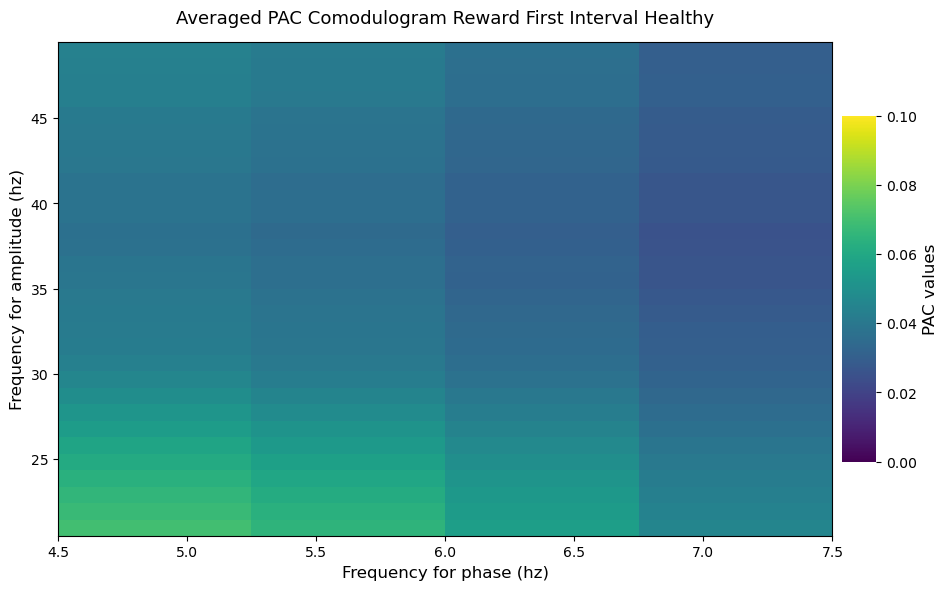

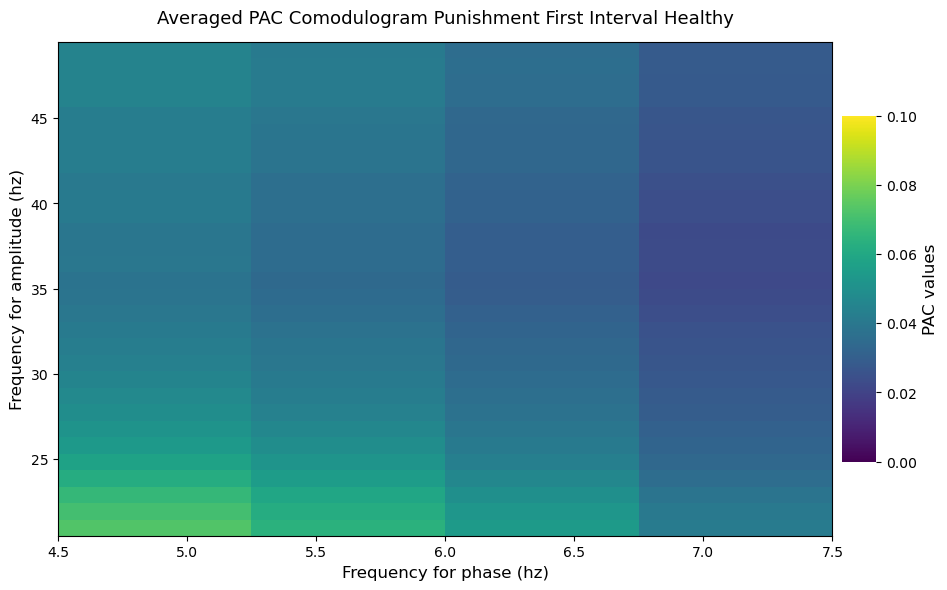

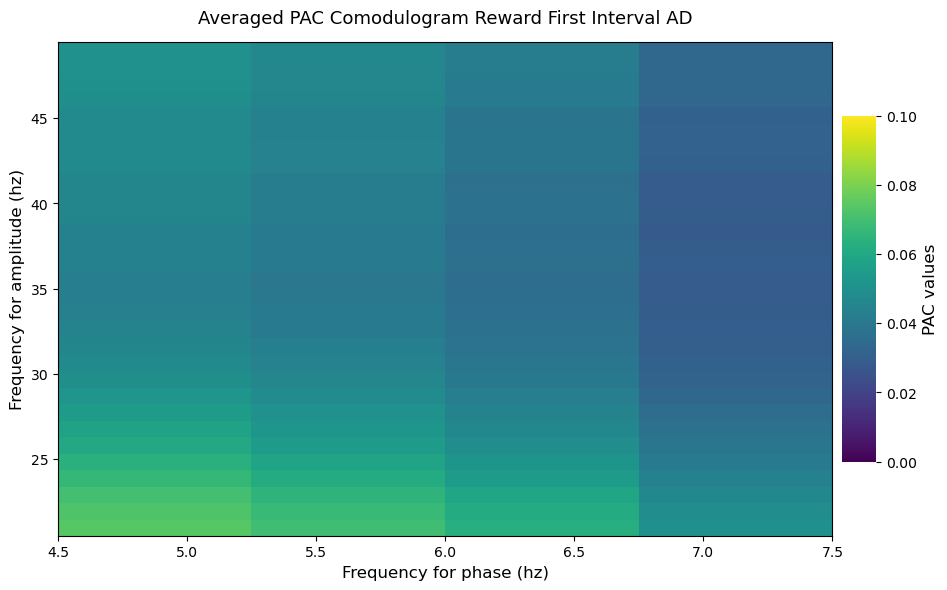

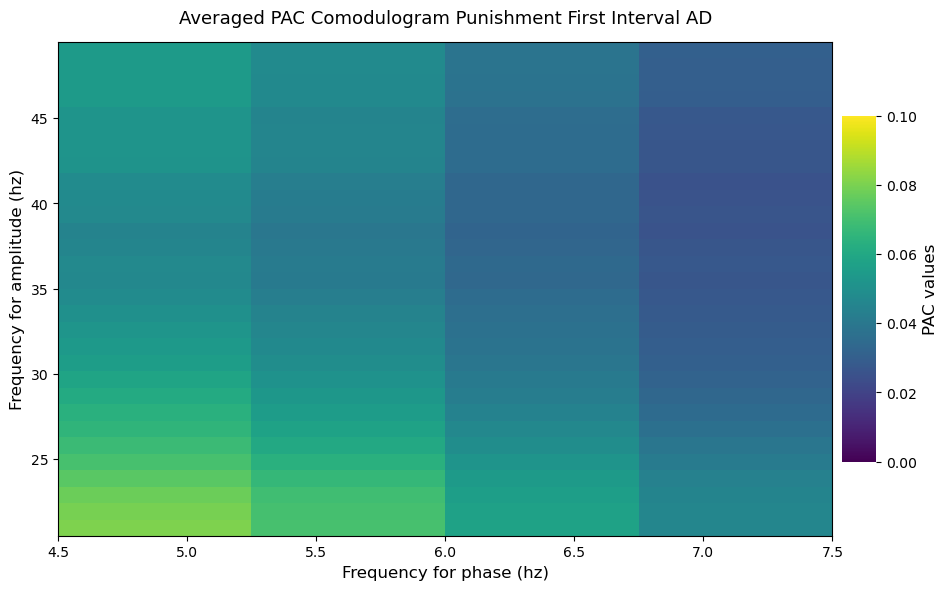

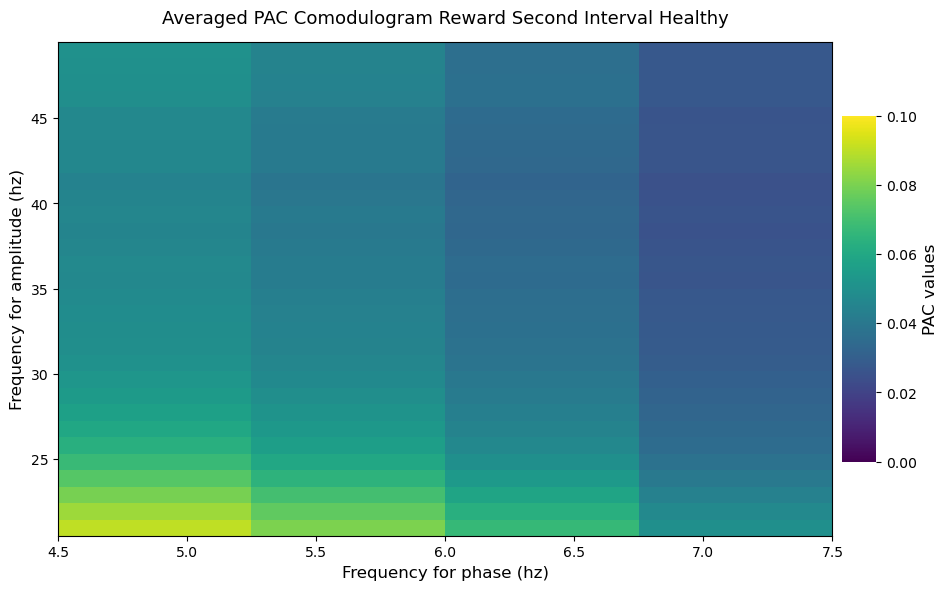

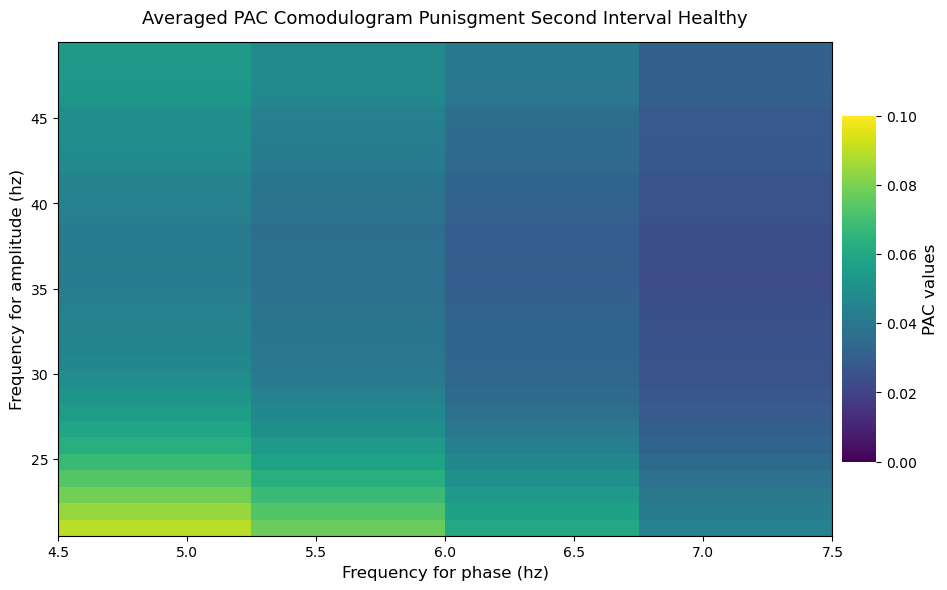

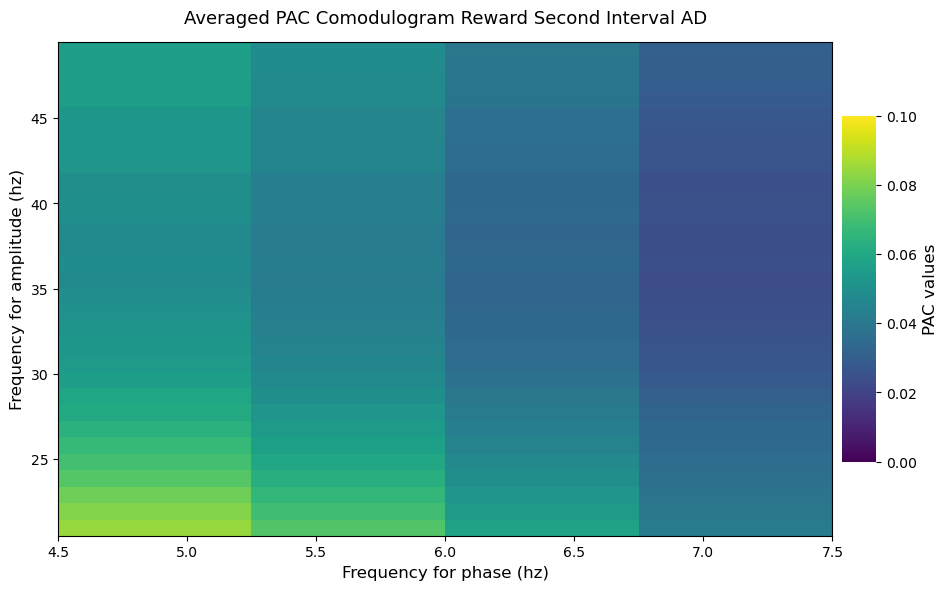

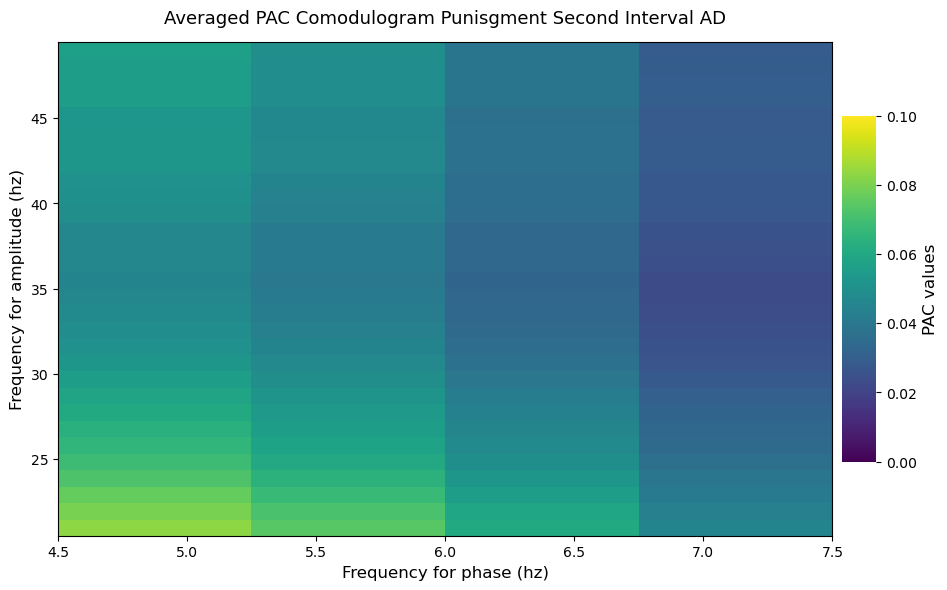

In [99]:
p_obj_reward_first_h, PAC_main_reward_first_h = calculate_PAC_Main(normalized_reward_trials_healthy, 200, 450)
p_obj_punishment_first_h, PAC_main_punishment_first_h = calculate_PAC_Main(normalized_punishment_trials_healthy, 200, 450)
p_obj_reward_first_a, PAC_main_reward_first_a = calculate_PAC_Main(normalized_reward_trials_AD, 200, 450)
p_obj_punishment_first_a, PAC_main_punishment_first_a = calculate_PAC_Main(normalized_punishment_trials_AD, 200, 450)

p_obj_reward_second_h, PAC_main_reward_second_h = calculate_PAC_Main(normalized_reward_trials_healthy, 450, 700)
p_obj_punishment_second_h, PAC_main_punishment_second_h = calculate_PAC_Main(normalized_punishment_trials_healthy, 450, 700)
p_obj_reward_second_a, PAC_main_reward_second_a = calculate_PAC_Main(normalized_reward_trials_AD, 450, 700)
p_obj_punishment_second_a, PAC_main_punishment_second_a = calculate_PAC_Main(normalized_punishment_trials_AD, 450, 700)

# Plot the comodulogram of the averaged PAC
plt.figure(figsize=(10, 6))
p_obj_reward_first_h.comodulogram(PAC_main_reward_first_h, title="Averaged PAC Comodulogram Reward First Interval Healthy", cmap='viridis', vmax=0.1, vmin=0)
plt.tight_layout()
plt.show()

# Plot the comodulogram of the averaged PAC
plt.figure(figsize=(10, 6))
p_obj_punishment_first_h.comodulogram(PAC_main_punishment_first_h, title="Averaged PAC Comodulogram Punishment First Interval Healthy", cmap='viridis', vmax=0.1, vmin=0)
plt.tight_layout()
plt.show()

# Plot the comodulogram of the averaged PAC
plt.figure(figsize=(10, 6))
p_obj_reward_first_a.comodulogram(PAC_main_reward_first_a, title="Averaged PAC Comodulogram Reward First Interval AD", cmap='viridis', vmax=0.1, vmin=0)
plt.tight_layout()
plt.show()

# Plot the comodulogram of the averaged PAC
plt.figure(figsize=(10, 6))
p_obj_punishment_first_a.comodulogram(PAC_main_punishment_first_a, title="Averaged PAC Comodulogram Punishment First Interval AD", cmap='viridis', vmax=0.1, vmin=0)
plt.tight_layout()
plt.show()

# Plot the comodulogram of the averaged PAC
plt.figure(figsize=(10, 6))
p_obj_reward_second_h.comodulogram(PAC_main_reward_second_h, title="Averaged PAC Comodulogram Reward Second Interval Healthy", cmap='viridis', vmax=0.1, vmin=0)
plt.tight_layout()
plt.show()

# Plot the comodulogram of the averaged PAC
plt.figure(figsize=(10, 6))
p_obj_punishment_second_h.comodulogram(PAC_main_punishment_second_h, title="Averaged PAC Comodulogram Punisgment Second Interval Healthy", cmap='viridis', vmax=0.1, vmin=0)
plt.tight_layout()
plt.show()

# Plot the comodulogram of the averaged PAC
plt.figure(figsize=(10, 6))
p_obj_reward_second_h.comodulogram(PAC_main_reward_second_a, title="Averaged PAC Comodulogram Reward Second Interval AD", cmap='viridis', vmax=0.1, vmin=0)
plt.tight_layout()
plt.show()

# Plot the comodulogram of the averaged PAC
plt.figure(figsize=(10, 6))
p_obj_punishment_second_h.comodulogram(PAC_main_punishment_second_a, title="Averaged PAC Comodulogram Punisgment Second Interval AD", cmap='viridis', vmax=0.1, vmin=0)
plt.tight_layout()
plt.show()

In [82]:
import numpy as np
from tensorpac import Pac
from tensorpac.methods import mean_vector_length

def compute_pac(p_obj, data_channel_1, data_channel_2):
    pha_p = p_obj.filter(500, data_channel_2, ftype='phase')
    amp_p = p_obj.filter(500, data_channel_1, ftype='amplitude')
    pac_result = mean_vector_length(pha_p, amp_p)
    return pac_result

def calculate_PAC_Shuffle(normalized_trials, start_timestep, end_timestep, num_permute=50):

    subject_count = normalized_trials.shape[0]
    channel_1 = 3  # 4th channel Fz
    channel_2 = 13  # 14th channel Pz
    trial_count = normalized_trials.shape[2]

    # Initialize PAC object with specified frequency ranges
    p_obj = Pac(idpac=(6, 0, 0), f_pha=(4, 9, 1, 1), f_amp=(20, 51, 1, 1))

    # List to store PAC values (2D arrays for each trial and subject)
    pac_perm = []  # To store permuted PAC values

    # Loop over each subject and trial to compute PAC
    for subject in range(subject_count):
        subject_data = normalized_trials[subject, :, :, :]  # Shape: (17, 20, 800)
        
        for trial in range(trial_count):
            # Extract the data for the 4th and 14th channels
            data_channel_1 = subject_data[channel_1, trial, start_timestep:end_timestep]  # Shape: (250,)
            data_channel_2 = subject_data[channel_2, trial, start_timestep:end_timestep]  # Shape: (250,)

            # Check if data contains NaN values in the original data
            if np.any(np.isnan(data_channel_1)) or np.any(np.isnan(data_channel_2)):
                continue  # Skip this trial if any NaN in the data

            permuted_pac_results = []  # To store PAC values for current trial's permutations
            for _ in range(num_permute):  # Number of permutations
                shuffled_data_channel_1 = np.random.permutation(data_channel_1)
                shuffled_data_channel_2 = np.random.permutation(data_channel_2)

                # Compute PAC for the permuted signals
                permuted_pac = compute_pac(p_obj, shuffled_data_channel_1, shuffled_data_channel_2)
                
                # Check if permuted PAC is valid (not NaN)
                if permuted_pac is not None and not np.any(np.isnan(permuted_pac)):
                    permuted_pac_results.append(permuted_pac)

            # Only append results if there were valid (non-NaN) permutations
            if permuted_pac_results:
                pac_perm.append(np.stack(permuted_pac_results))

    pac_perm = np.array(pac_perm)
    pac_perm = pac_perm.squeeze()  # Remove the singleton dimension

    # Average across trials to get a mean PAC for each frequency pair
    pac_perm_avg = np.mean(pac_perm, axis=0)

    return p_obj, pac_perm_avg

In [100]:
p_obj_perm_reward_first_h, PAC_perm_reward_first_h = calculate_PAC_Shuffle(normalized_reward_trials_healthy, 200, 450, num_permute = 50)
p_obj_perm_punishment_first_h, PAC_perm_punishment_first_h = calculate_PAC_Shuffle(normalized_punishment_trials_healthy, 200, 450, num_permute = 50)
p_obj_perm_reward_first_a, PAC_perm_reward_first_a = calculate_PAC_Shuffle(normalized_reward_trials_AD, 200, 450, num_permute = 50)
p_obj_perm_punishment_first_a, PAC_perm_punishment_first_a = calculate_PAC_Shuffle(normalized_punishment_trials_AD, 200, 450, num_permute = 50)

p_obj_perm_reward_second_h, PAC_perm_reward_second_h = calculate_PAC_Shuffle(normalized_reward_trials_healthy, 450, 700, num_permute = 50)
p_obj_perm_punishment_second_h, PAC_perm_punishment_second_h = calculate_PAC_Shuffle(normalized_punishment_trials_healthy, 450, 700, num_permute = 50)
p_obj_perm_reward_second_a, PAC_perm_reward_second_a = calculate_PAC_Shuffle(normalized_reward_trials_AD, 450, 700, num_permute = 50)
p_obj_perm_punishment_second_a, PAC_perm_punishment_second_a = calculate_PAC_Shuffle(normalized_punishment_trials_AD, 450, 700, num_permute = 50)

Phase Amplitude Coupling object defined
Phase Amplitude Coupling object defined
Phase Amplitude Coupling object defined
Phase Amplitude Coupling object defined
Phase Amplitude Coupling object defined
Phase Amplitude Coupling object defined
Phase Amplitude Coupling object defined
Phase Amplitude Coupling object defined


In [101]:
import numpy as np
from scipy import stats

def compute_p_values(PAC_main, PAC_perm):
    # PAC_main shape: (30, 4)  -> observed PAC values (frequencies of amp x frequencies of phase)
    # PAC_perm shape: (50, 30, 4) -> permuted PAC values (num_perm, amp_freqs, phase_freqs)
    
    # Initialize a p-value array with the same shape as PAC_main (30, 4)
    p_values = np.zeros(PAC_main.shape)
    
    # Loop over each frequency pair (i, j) corresponding to (amp_freq, phase_freq)
    for i in range(PAC_main.shape[0]):  # Loop over amp_freq (30)
        for j in range(PAC_main.shape[1]):  # Loop over phase_freq (4)
            
            # Perform a one-sample t-test for each (i, j) pair
            t_stat, p_val = stats.ttest_1samp(PAC_perm[:, i, j], PAC_main[i, j], alternative='less')
            
            p_values[i, j] = p_val 
    
    return p_values

p_values_reward_first_h = compute_p_values(PAC_main_reward_first_h, PAC_perm_reward_first_h)
p_values_punishment_first_h = compute_p_values(PAC_main_punishment_first_h, PAC_perm_punishment_first_h)
p_values_reward_second_h = compute_p_values(PAC_main_reward_second_h, PAC_perm_reward_second_h)
p_values_punishment_second_h = compute_p_values(PAC_main_punishment_second_h, PAC_perm_punishment_second_h)

p_values_reward_first_a = compute_p_values(PAC_main_reward_first_a, PAC_perm_reward_first_a)
p_values_punishment_first_a = compute_p_values(PAC_main_punishment_first_a, PAC_perm_punishment_first_a)
p_values_reward_second_a = compute_p_values(PAC_main_reward_second_a, PAC_perm_reward_second_a)
p_values_punishment_second_a = compute_p_values(PAC_main_punishment_second_a, PAC_perm_punishment_second_a)


In [102]:
PAC_main_reward_first_h[p_values_reward_first_h > 0.05] = 0
PAC_main_punishment_first_h[p_values_punishment_first_h > 0.05] = 0
PAC_main_reward_second_h[p_values_reward_second_h > 0.05] = 0
PAC_main_punishment_second_h[p_values_punishment_second_h > 0.05] = 0

PAC_main_reward_first_a[p_values_reward_first_a > 0.05] = 0
PAC_main_punishment_first_a[p_values_punishment_first_a > 0.05] = 0
PAC_main_reward_second_a[p_values_reward_second_a > 0.05] = 0
PAC_main_punishment_second_a[p_values_punishment_second_a > 0.05] = 0

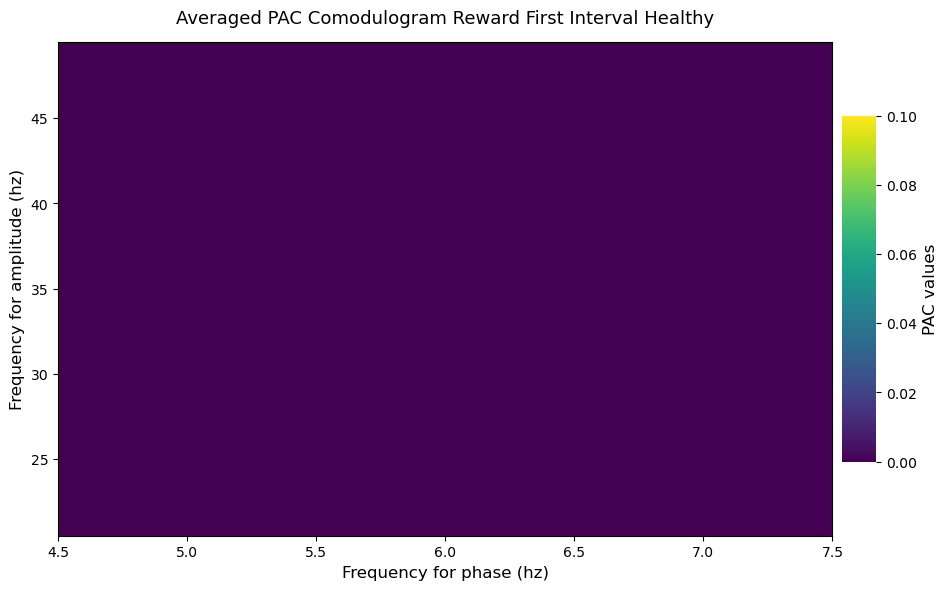

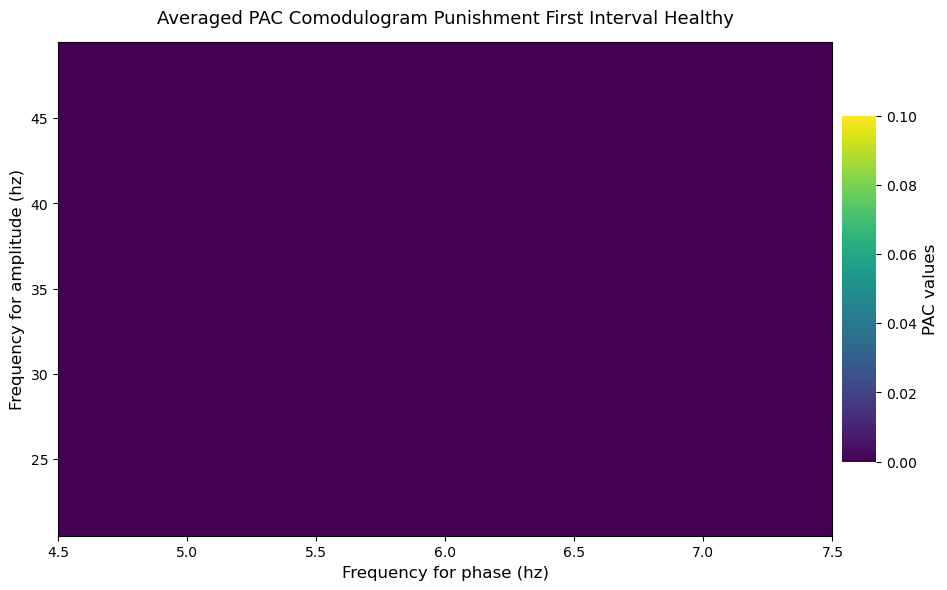

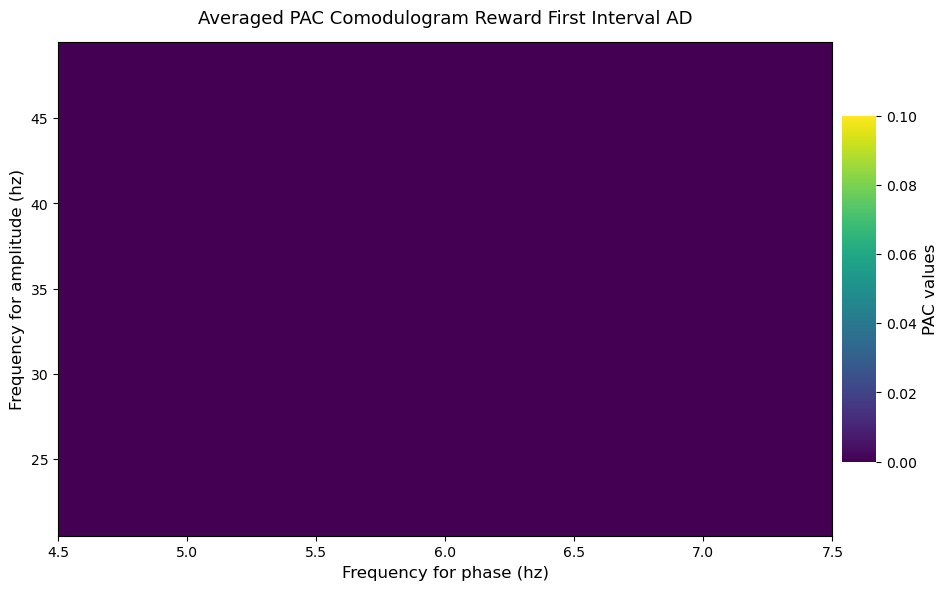

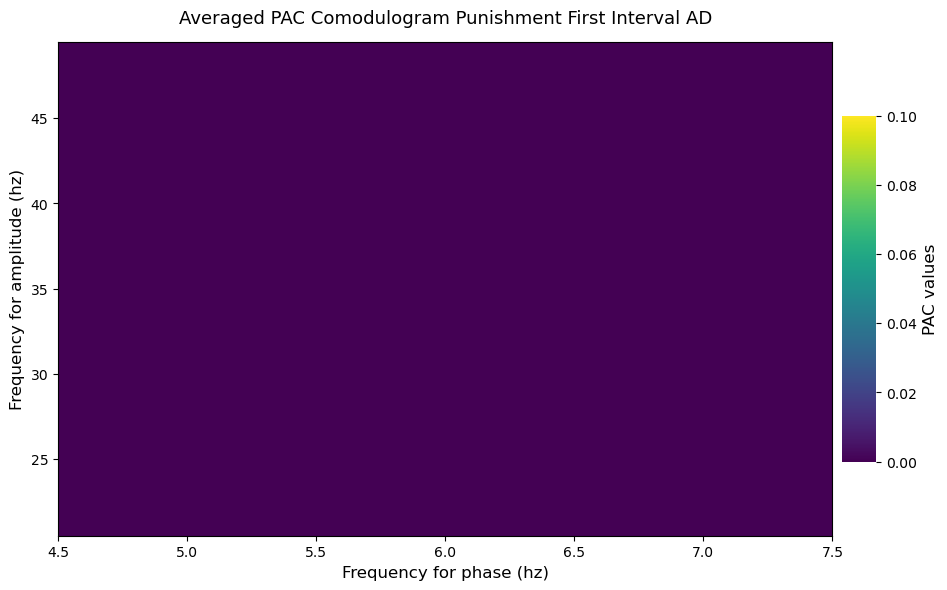

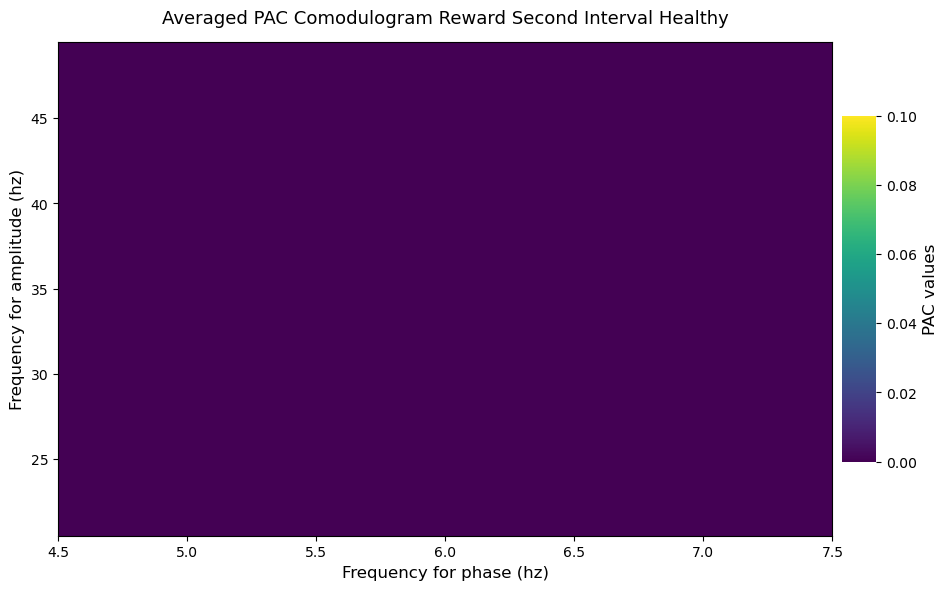

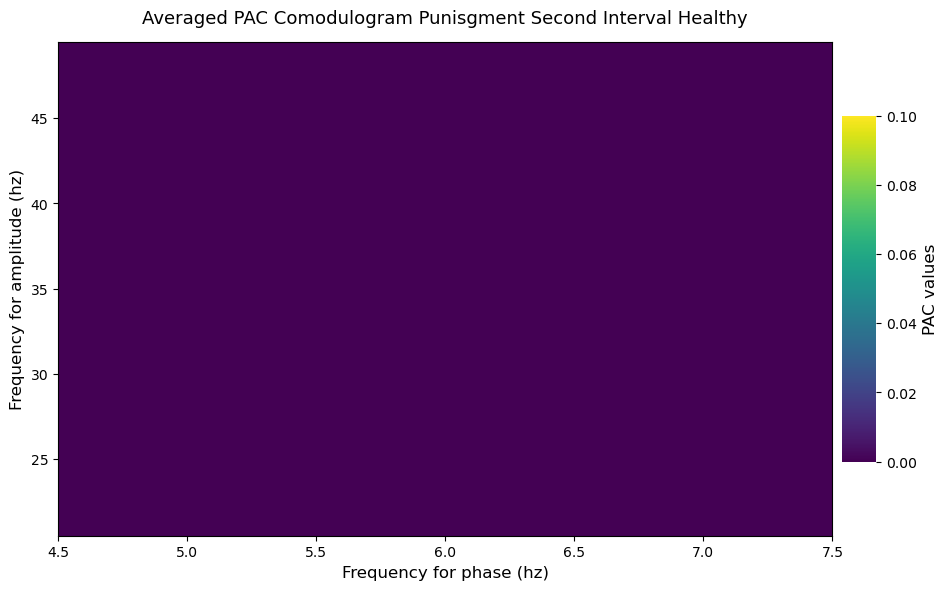

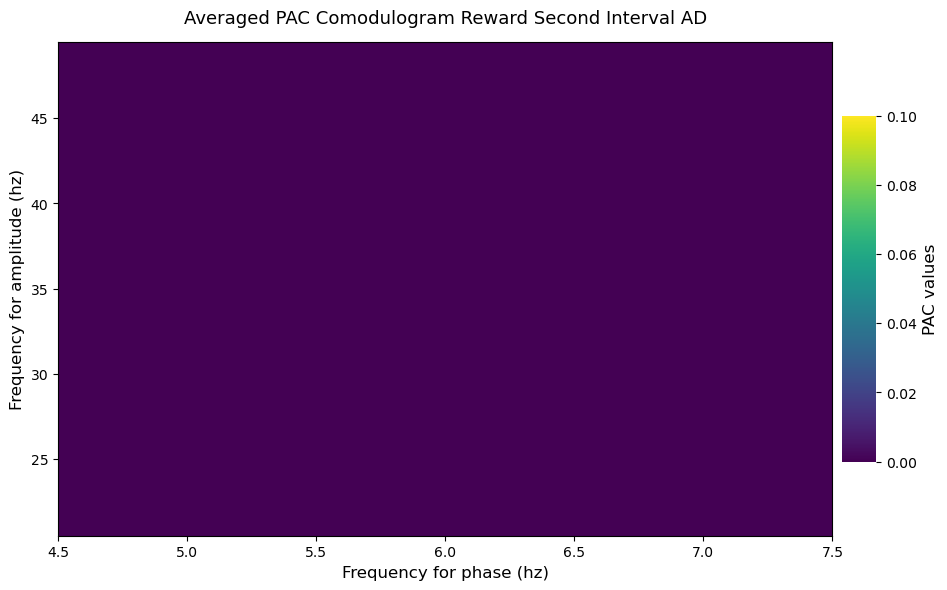

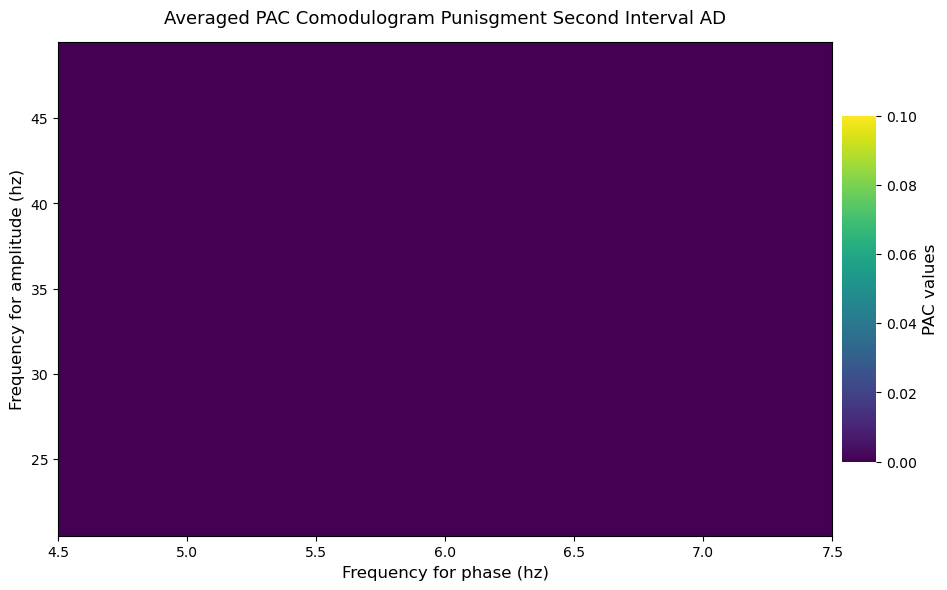

In [103]:
# Plot the comodulogram of the averaged PAC
plt.figure(figsize=(10, 6))
p_obj_reward_first_h.comodulogram(PAC_main_reward_first_h, title="Averaged PAC Comodulogram Reward First Interval Healthy", cmap='viridis', vmax=0.1, vmin=0)
plt.tight_layout()
plt.show()

# Plot the comodulogram of the averaged PAC
plt.figure(figsize=(10, 6))
p_obj_punishment_first_h.comodulogram(PAC_main_punishment_first_h, title="Averaged PAC Comodulogram Punishment First Interval Healthy", cmap='viridis', vmax=0.1, vmin=0)
plt.tight_layout()
plt.show()

# Plot the comodulogram of the averaged PAC
plt.figure(figsize=(10, 6))
p_obj_reward_first_a.comodulogram(PAC_main_reward_first_a, title="Averaged PAC Comodulogram Reward First Interval AD", cmap='viridis', vmax=0.1, vmin=0)
plt.tight_layout()
plt.show()

# Plot the comodulogram of the averaged PAC
plt.figure(figsize=(10, 6))
p_obj_punishment_first_a.comodulogram(PAC_main_punishment_first_a, title="Averaged PAC Comodulogram Punishment First Interval AD", cmap='viridis', vmax=0.1, vmin=0)
plt.tight_layout()
plt.show()

# Plot the comodulogram of the averaged PAC
plt.figure(figsize=(10, 6))
p_obj_reward_second_h.comodulogram(PAC_main_reward_second_h, title="Averaged PAC Comodulogram Reward Second Interval Healthy", cmap='viridis', vmax=0.1, vmin=0)
plt.tight_layout()
plt.show()

# Plot the comodulogram of the averaged PAC
plt.figure(figsize=(10, 6))
p_obj_punishment_second_h.comodulogram(PAC_main_punishment_second_h, title="Averaged PAC Comodulogram Punisgment Second Interval Healthy", cmap='viridis', vmax=0.1, vmin=0)
plt.tight_layout()
plt.show()

# Plot the comodulogram of the averaged PAC
plt.figure(figsize=(10, 6))
p_obj_reward_second_h.comodulogram(PAC_main_reward_second_a, title="Averaged PAC Comodulogram Reward Second Interval AD", cmap='viridis', vmax=0.1, vmin=0)
plt.tight_layout()
plt.show()

# Plot the comodulogram of the averaged PAC
plt.figure(figsize=(10, 6))
p_obj_punishment_second_h.comodulogram(PAC_main_punishment_second_a, title="Averaged PAC Comodulogram Punisgment Second Interval AD", cmap='viridis', vmax=0.1, vmin=0)
plt.tight_layout()
plt.show()